In [1]:
!pip install tensorflow==2.17.0 keras==3.4.1 tensorflow-decision-forests==1.10.0 tensorflow-text==2.17.0 tf-keras==2.17.0 keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.3 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 7.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 97.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.7 MB/s eta 0:00:0000:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1

## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

## ⚙️ Import Libraries

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import layers as layers
import keras
import keras_cv
from sklearn.model_selection import train_test_split


np.random.seed(42)
tf.random.set_seed(42);

In [ ]:
PATH_TRAINING_SET = ""
assert PATH_TRAINING_SET != "", "PATH_TRAINING_SET cannot be empty."

## ⏳ Load the Data

In [9]:
data = np.load(PATH_TRAINING_SET)
X = data['images']
y = data['labels']

## Preprocessing

### Removing duplicates (outliers)

In [10]:
import hashlib

def image_hash(image):
    image_bytes = image.tobytes()
    return hashlib.sha256(image_bytes).hexdigest()

unique_images = []
unique_labels = []
duplicate_positions = set()

seen_hashes = {}

for i in range(len(X)):
    img_hash = image_hash(X[i])
    if img_hash not in seen_hashes:
        if i not in duplicate_positions:
            unique_images.append(X[i])
            unique_labels.append(y[i])
        seen_hashes[img_hash] = i
    else:
        duplicate_positions.add(seen_hashes[img_hash])
        duplicate_positions.add(i)

X = [X[i] for i in range(len(X)) if i not in duplicate_positions]
y = [y[i] for i in range(len(y)) if i not in duplicate_positions]

X = np.array(X)
y = np.array(y)


### Balancing the classes

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
])

# Extract unique classes and their counts
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Original distribution:", class_counts)

# Maximum number of samples for a class
max_samples = max(class_counts.values())

# New balanced dataset
X_balanced = []
y_balanced = []

# Oversampling for each class
for cls in class_counts:
    # Filter samples for the current class
    X_class = X[np.where(y == cls)[0]]
    y_class = y[y == cls]
    
    # Calculate the number of samples to add
    samples_to_add = max_samples - len(X_class)
    
    if samples_to_add > 0:
        # Augment the samples to add
        augmented_images = []
        for _ in range(samples_to_add):
            augmented_image = data_augmentation(X_class[np.random.randint(len(X_class))][np.newaxis, ...])
            augmented_images.append(augmented_image.numpy()[0])
        
        # Add the original and augmented samples to the balanced dataset
        X_balanced.append(np.concatenate([X_class, np.array(augmented_images)]))
        y_balanced.append(np.concatenate([y_class, np.full(samples_to_add, cls)]))
    else:
        # Add the original samples to the balanced dataset (if no oversampling is needed)
        X_balanced.append(X_class)
        y_balanced.append(y_class)

# Concatenate the balanced dataset
X = np.concatenate(X_balanced)
y = np.concatenate(y_balanced)

# Check the new distribution
unique_balanced, counts_balanced = np.unique(y_balanced, return_counts=True)
class_counts_balanced = dict(zip(unique_balanced, counts_balanced))
print("Balanced distribution of classes:", class_counts_balanced)


I0000 00:00:1732302123.218743      30 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732302123.219137      30 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732302123.239147      30 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732302123.239465      30 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Original distribution: {0: 848, 1: 2177, 2: 1085, 3: 2020, 4: 849, 5: 991, 6: 2330, 7: 1643}
Balanced distribution of classes: {0: 2330, 1: 2330, 2: 2330, 3: 2330, 4: 2330, 5: 2330, 6: 2330, 7: 2330}


In [15]:
# Converts in one-hot-encoding
y = tf.keras.utils.to_categorical(y, num_classes=8)

## Splitting in training, validation e test set

In [16]:
# split train in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [17]:
# split train in training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

### Data augmentation

In [18]:
def sample_random_images(dataset, sample_size=5):
    random_samples = dataset.shuffle(buffer_size=1000).take(sample_size)
    images = []
    labels = []
    for image, label in random_samples:
        images.append(image.numpy())
        labels.append(label.numpy())
    return tf.convert_to_tensor(images), tf.convert_to_tensor(labels)

X_train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

In [19]:
def augment(images, labels):
    
    augmenter = keras_cv.layers.Augmenter(
    layers = [
            keras_cv.layers.RandomFlip(
                mode="horizontal_and_vertical"
            ),
            keras_cv.layers.RandomRotation(
                factor=0.2,
                fill_mode='nearest'
            ),
            keras_cv.layers.MixUp(
                alpha=0.5,
            ),
            keras_cv.layers.CutMix(
                alpha=0.5
            ),

            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),

        ]
    )
        
    inputs = {"images": images, "labels": labels}
    output = augmenter(inputs)
    return output["images"], output["labels"]

In [20]:
random_X, random_y = sample_random_images(X_train_dataset, 4000)
aug_images, aug_labels = augment(random_X, random_y)

In [21]:
X_train = tf.concat([X_train, aug_images], axis=0)
y_train = tf.concat([y_train, aug_labels], axis=0)

In [22]:
randaugmenter = tf.keras.Sequential([
    keras_cv.layers.RandAugment([0, 255], 3, 0.4)
])

augmix = tf.keras.Sequential([
    keras_cv.layers.AugMix([0, 255])
])

def apply_randaugment(image):
    return randaugmenter(image)

def apply_augmix(image):
    return augmix(image)

def apply_augmentation(image, is_randaugment):
    if is_randaugment:
        return apply_randaugment(image)
    else:
        return apply_augmix(image)

batch_size = 256
half_size = len(X_train) // 2

dataset_randaugment = tf.data.Dataset.from_tensor_slices(X_train[:half_size])
dataset_randaugment = dataset_randaugment.map(lambda x: apply_augmentation(x, is_randaugment=True), num_parallel_calls=tf.data.AUTOTUNE)

dataset_augmix = tf.data.Dataset.from_tensor_slices(X_train[half_size:])
dataset_augmix = dataset_augmix.map(lambda x: apply_augmentation(x, is_randaugment=False), num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset_randaugment.concatenate(dataset_augmix)
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

X_train = tf.concat([batch for batch in dataset], axis=0)

del X_train_dataset

### Plotting some augmented images

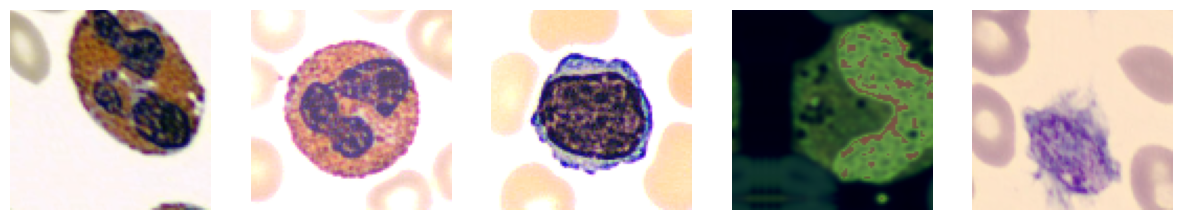

In [26]:
import matplotlib.pyplot as plt

num_images = 5
plt.figure(figsize=(15, 5))  # Adjust the figure size as needed

for i in range(num_images):
    plt.subplot(1, num_images, i + 1)  # Create a 1-row subplot for 10 images
    plt.imshow(X_train[i] / 255.0)    # Normalize and plot each image
    plt.axis('off')                  # Turn off axis labels for clarity

plt.show()

## 🛠️ Train and Save the Model

In [30]:
class MyModel:
    def __init__(self):
        """
        Initializes the internal state of the pre-trained MobileNetV3Small model.
        """
        self.strategy = tf.distribute.MirroredStrategy()
        self.neural_network = self.create_model()
        
    def get_augmentation_layer(self):
        return tf.keras.Sequential([
            # Random rotation
            keras.layers.RandomRotation(0.5, fill_mode='reflect'),

            # Random zoom in height
            keras.layers.RandomZoom(height_factor=(-0.2, 0.7), fill_mode='nearest'),

            # Other types of augmentations
            keras.layers.RandomZoom(height_factor=(0.0, 0.0), width_factor=(-0.3, 0.3), fill_mode='nearest'),
            keras.layers.RandomFlip(mode="horizontal"),
            keras.layers.RandomFlip(mode="vertical"),
            keras.layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
            
            keras.layers.RandomBrightness(0.3),
            #keras_cv.layers.RandomHue(0.3, [0,255]),
            keras_cv.layers.RandomContrast([0, 255], 0.3),
            keras_cv.layers.RandomGaussianBlur(2, 2),
            #keras_cv.layers.RandomCutout(0.3, 0.3,"gaussian_noise"),

            # Adding Gaussian noise
            keras.layers.GaussianNoise(0.07)
        ])

    def create_model(self):
        """
        Creates and returns a model
        """
        # Define data augmentation layers
        data_augmentation = self.get_augmentation_layer()
        
        with self.strategy.scope():

            # Use a pre-trained network
            model_pretrained = tfk.applications.ConvNeXtBase(
                input_shape=(96, 96, 3),
                include_top=False,
                weights='imagenet',
                pooling=None
            )
            self.model_name_pretrained = 'convnext_base'

            print("number of layers:")
            print(len(model_pretrained.layers))

            # Build the model
            inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')    
            x = data_augmentation(inputs)
            x = model_pretrained(x) 
            
            # Batch Normalization after the pre-trained model
            x = tfk.layers.BatchNormalization()(x)

            # Squeeze-and-Excitation (SE Block)
            se = tfk.layers.GlobalAveragePooling2D()(x)  # Reduces to (batch_size, channels)
            se = tfk.layers.Dense(se.shape[-1] // 16, activation='relu')(se)  # Compress
            se = tfk.layers.Dense(se.shape[-1] * 16, activation='sigmoid')(se)  # Expand
            x = tfk.layers.Multiply()([x, tfk.layers.Reshape((1, 1, -1))(se)])  # Scale channels

            # Global Pooling (to reduce dimensionality)
            x = tfk.layers.GlobalAveragePooling2D()(x)

            # Fully Connected layers with Batch Normalization and Leaky ReLU
            x = tfk.layers.Dense(512)(x)
            x = tfk.layers.BatchNormalization()(x)
            x = tfk.layers.LeakyReLU(alpha=0.1)(x)
            x = tfk.layers.Dropout(0.3)(x)

            x = tfk.layers.Dense(256)(x)
            x = tfk.layers.BatchNormalization()(x)
            x = tfk.layers.LeakyReLU(alpha=0.1)(x)
            x = tfk.layers.Dropout(0.3)(x)
            
            outputs = tfk.layers.Dense(8, activation='softmax', name='output_layer')(x)

            model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

            return model

    def train_transfer_learning(self, X_train, y_train, X_test, y_test, epochs=10, batch_size=32):
        """
        Pre-trains the model with frozen layers.
        """

        with self.strategy.scope():  # Ensure training happens inside strategy scope

            self.neural_network.get_layer(self.model_name_pretrained).trainable = False

            # Unlock convolutional layers from the `fine_tune_from` layer onward
            for i, layer in enumerate(self.neural_network.get_layer(self.model_name_pretrained).layers):
                layer.trainable = False

            # Recompile the model (necessary after changing trainable layers)
            self.neural_network.compile(
                loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Lion(learning_rate=1e-3),
                metrics=['accuracy']
            )

            # Callbacks
            save_every_10 = LambdaCallback(
                on_epoch_end=lambda epoch, logs:
                self.neural_network.save(f'model_epoch_{epoch + 1}.keras') if (epoch + 1) % 10 == 0 else None
            )
            early_stopping = tfk.callbacks.EarlyStopping(
                monitor='val_accuracy',
                mode='max',
                patience=10,
                restore_best_weights=True
            )
        
            # Retrain the model
            history = self.neural_network.fit(
                X_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[save_every_10, early_stopping]
            )

            return history

    def train_fine_tuning(self, X_train, y_train, X_test, y_test, epochs=10, batch_size=32, fine_tune_from=50):
        """
        Unlocks selected layers and retrains the model.
        """

        with self.strategy.scope():  # Ensure training happens inside strategy scope

            self.neural_network.get_layer(self.model_name_pretrained).trainable = True

            # Unlock convolutional layers from the `fine_tune_from` layer onward
            for i, layer in enumerate(self.neural_network.get_layer(self.model_name_pretrained).layers):
                layer.trainable = False
                if i > fine_tune_from:
                    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
                        print(True)  
                        layer.trainable = True

            # Recompile the model with a lower learning rate
            self.neural_network.compile(
                loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Lion(learning_rate=1e-4),
                metrics=['accuracy']
            )

            # Callbacks
            save_every_10 = LambdaCallback(
                on_epoch_end=lambda epoch, logs:
                self.neural_network.save(f'model_epoch_{epoch + 1}.keras') if (epoch + 1) % 10 == 0 else None
            )
            early_stopping = tfk.callbacks.EarlyStopping(
                monitor='val_accuracy',
                mode='max',
                patience=10,
                restore_best_weights=True
            )
            
            # Retrain the model
            history = self.neural_network.fit(
                X_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[save_every_10, early_stopping]
            )
            
            return history

    
    def plot_history(self, history):
        # Extract the history data
        history_data = history.history
    
        # Extract the number of epochs
        epochs = range(1, len(history_data["loss"]) + 1)
    
        # Plot loss and validation loss
        plt.figure(figsize=(14, 5))
    
        # Subplot 1: Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history_data["loss"], label="Training Loss", marker="o")
        plt.plot(epochs, history_data["val_loss"], label="Validation Loss", marker="o")
        plt.title("Training and Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
    
        # Subplot 2: Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history_data["accuracy"], label="Training Accuracy", marker="o")
        plt.plot(epochs, history_data["val_accuracy"], label="Validation Accuracy", marker="o")
        plt.title("Training and Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
    
        # Show the plots
        plt.tight_layout()
        plt.show()


    def test(self, X_test, y_test):
        """
        Evaluates the model on test data X_test and labels y_test.
        """
        test_loss, test_acc = self.neural_network.evaluate(X_test, y_test)
        print(f'Test accuracy: {test_acc}')
        
    def load(self, path):
        """
        Loads a model from the specified path.
        """
        with self.strategy.scope():
            self.neural_network = tfk.models.load_model(path) 
            self.neural_network.compile(
                loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Lion(),
                metrics=['accuracy']
            )
    
    def save(self):
        """
        Saves the model without data augmentation layers.
        """
        self.neural_network.save('/gdrive/MyDrive/[2024-2025] AN2DL/Homework 1/weights.keras')

    def predict(self, X):
        """
        Predicts labels for the input X.
        """
        preds = self.neural_network.predict(X)
        return preds


In [31]:
model = MyModel()

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
number of layers:
259


/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [23]:
history = model.train_transfer_learning(augmented_X, y_train, X_test, y_test, 50, 512)
model.plot_history(history)

Epoch 1/50


W0000 00:00:1732107752.508086     109 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732107752.511350     109 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732107752.514461     111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732107752.514923     109 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732107752.517739     111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732107752.518660     109 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732107752.522428     109 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732107752.522459     111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732107752.525408     109 gp

40/41 ━━━━━━━━━━━━━━━━━━━━ 25s 26s/step - accuracy: 0.3200 - loss: 1.9521

W0000 00:00:1732108791.878209     110 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732108791.879416     111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732108791.880724     110 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732108791.881741     111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732108791.883258     110 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732108791.884275     111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732108791.885777     110 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732108791.886795     111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732108791.888134     110 gp

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.3227 - loss: 1.9440 

W0000 00:00:1732108894.449731     111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732108894.452149     111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732108894.454811     111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732108894.455826     109 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732108894.457460     111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732108894.459357     109 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732108894.460343     111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732108894.462791     111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732108894.462869     109 gp

41/41 ━━━━━━━━━━━━━━━━━━━━ 1208s 28s/step - accuracy: 0.3254 - loss: 1.9363 - val_accuracy: 0.7210 - val_loss: 0.9636
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1146s 28s/step - accuracy: 0.5912 - loss: 1.1914 - val_accuracy: 0.8326 - val_loss: 0.8741
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1166s 28s/step - accuracy: 0.6413 - loss: 1.0651 - val_accuracy: 0.8981 - val_loss: 0.5114
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1167s 29s/step - accuracy: 0.6721 - loss: 0.9927 - val_accuracy: 0.9099 - val_loss: 0.4440
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1145s 28s/step - accuracy: 0.6812 - loss: 0.9608 - val_accuracy: 0.8830 - val_loss: 0.5037
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1145s 28s/step - accuracy: 0.6867 - loss: 0.9413 - val_accuracy: 0.9034 - val_loss: 0.3736
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1146s 28s/step - accuracy: 0.6967 - loss: 0.9281 - val_accuracy: 0.9206 - val_loss: 0.2891
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1143s 28s/step - accuracy: 0.7066 - loss: 0.8926 - val_accuracy: 0.906

KeyboardInterrupt: 

In [ ]:
history = model.train_fine_tuning(augmented_X, y_train, X_test, y_test, 50, 512, 150)
model.plot_history(history)

## Evaluation

In [33]:
model.test(X_test, y_test)

W0000 00:00:1732302963.007646     250 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732302963.007716     252 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732302963.108348     250 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732302963.108908     252 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732302963.110479     252 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732302963.110468     250 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732302963.111864     250 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732302963.111887     252 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732302963.114295     252 gp

58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9695 - loss: 0.0912

W0000 00:00:1732302979.283618     253 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732302979.284279     252 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732302979.284942     253 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732302979.286607     252 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732302979.287118     253 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732302979.288279     252 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732302979.288817     253 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732302979.290485     252 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732302979.291004     253 gp

59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 249ms/step - accuracy: 0.9695 - loss: 0.0912
Test accuracy: 0.9699570536613464


Evaluating with augmented test set

In [34]:
randaugmenter = tf.keras.Sequential([
    keras_cv.layers.RandAugment([0, 255], 3, 0.4)
])

augmented_test = randaugmenter(X_test)
augmented_test = model.get_augmentation_layer()(augmented_test)

In [35]:
model.test(augmented_test, y_test)

59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.8128 - loss: 0.5380
Test accuracy: 0.8165236115455627


### Plotting confusion matrix

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

def plot_confusion_matrix(y_true, y_pred):
    
    cm = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)  
    plt.title("Confusion Matrix")
    plt.show()


def evaluate_model(y_true, y_pred):
    # Convert one-hot encoding to class labels for precision, recall, and accuracy
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:
        y_true_labels = np.argmax(y_true, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
    else:
        y_true_labels = y_true
        y_pred_labels = y_pred

    # Compute metrics
    precision = precision_score(y_true_labels, y_pred_labels, average="weighted")
    recall = recall_score(y_true_labels, y_pred_labels, average="weighted")
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    roc_auc = roc_auc_score(y_true, y_pred, multi_class="ovr")

    # Print metrics
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step
Precision: 0.9741
Recall: 0.9721
Accuracy: 0.9721
ROC AUC: 0.9992


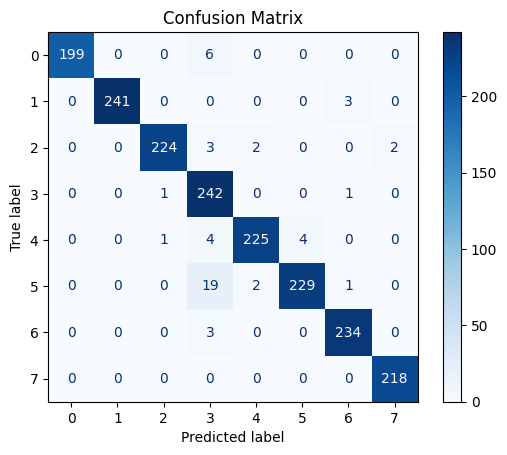

In [42]:
preds = model.predict(X_test)
evaluate_model(y_test, preds)

Evaluating with augmented test set

59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step
Precision: 0.8157
Recall: 0.8138
Accuracy: 0.8138
ROC AUC: 0.9791


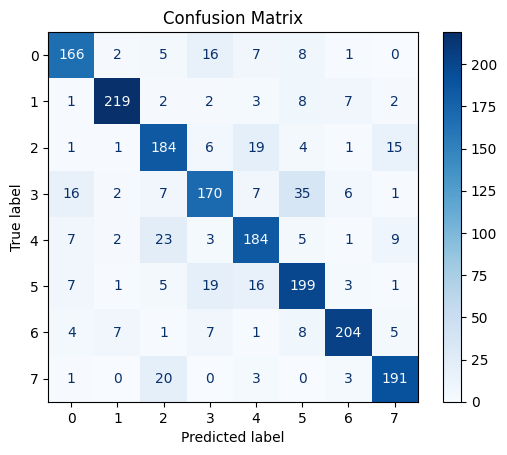

In [41]:
preds_augmented = model.predict(augmented_test)
evaluate_model(y_test, preds_augmented)

## 📊 Saving

In [ ]:
model.neural_network.save('weights.keras')

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)